# Welcome to WoW Log Data Parsing Project


### Abstract

In what follows, we parse data sets which are produced by World of Warcrafts server generator in real time in-game combat. We will attempt to establish certain relationships between the data and obtain some insights about the general in-game structure. We will choose various encounters and find each spell participation in damage counts. Moreover, we will plot, over time, the cumulative damage for each spell and consequently we will graph the mitigated and unmitigated damage values. Finally, we will plot the real time DPS. In the future, I want to evaluate the gini coefficients for the spell values and construct some confidence intervals for the over DPS.

If you are interested in this work and want to collaborate or ask anything in regards to it, please by all means contact me to discuss further any concerns you may have. You can always reach me on my email "nicolechantzi@gmail.com" or on discord "NicoleCh123#0908".

In [1]:
import os
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import datetime
from events import *
from customcanvas import Canvas
from sim import *
%matplotlib inline

In [2]:
wow_dir = 'C:\Program Files (x86)\World of Warcraft\_classic_\Logs'

In [3]:
 def fetch_log_paths() -> List[str]:
    return [os.path.join(wow_dir,filename) for filename in os.listdir(wow_dir) if (filename.startswith("WoWCombatLog") and filename.endswith('.txt'))]

def fetch_newest_log_path() -> str:
     return max(fetch_log_paths() , key = os.path.getctime)

In [4]:
path = fetch_newest_log_path()
path

'C:\\Program Files (x86)\\World of Warcraft\\_classic_\\Logs\\WoWCombatLog-100321_144034.txt'

In [5]:
with open(path,'r+',encoding='utf-8') as log:
    data = log.readlines()
    

encounter_datetime = data[0].split(',')[0].split(' ')[:-2]
encounter_datetime = ' '.join(encounter_datetime)
encounter_datetime = encounter_datetime.replace('/','-')
encounter_datetime = str(datetime.datetime.now().year) + '-' + encounter_datetime
encounter_datetime

'2021-10-3 14:40:34.059'

### Encounter Names

In [6]:
encounters = set()
for row in data:
    row = row.split(',')
    event = row[0].split(' ')[-1]
    if event == 'ENCOUNTER_START':
        encounters.add(row[2].replace('\"',''))
encounters = list(encounters)
encounters

["Warbringer O'mrogg", 'Blood Guard Porung', 'Warchief Kargath Bladefist']

### Player Names

In [7]:
players = set()
for row in data:
    row = row.split(',')
    event = row[0].split(' ')[-1]
    if event in Event.admissibleEvents:
        if 'Player' in row[1]:
            players.add(row[2].replace('\"','').split('-')[0])
        elif 'Player' in row[5]:
            players.add(row[6].replace('\"','').split('-')[0])
players = list(players)
players

['Vivaronaldo', 'Jødekoen', 'Oxyboo', 'Slaghter', 'Lollitta']

### Finding encounter timers and players

In [8]:
encounter_data = {encounter:{'players':set(),
                             'encounter_starts':None,
                            'encounter_ends':None} 
                  for encounter in encounters}
flag = False
for row in data:
    row = row.split(',')
    event = row[0].split(' ')[-1]
    if event == 'ENCOUNTER_START':
        flag = True
        encounter_name = row[2].replace('\"','')
        encounter_data[encounter_name]['encounter_starts'] = str(datetime.datetime.now().year) + '-' + ' '.join(row[0].replace('/','-').split(' ')[:2])
    elif flag:
        if event in Event.admissibleEvents:
            if 'Player' in row[1]:
                 encounter_data[encounter_name]['players'].add(row[2].replace('\"','').split('-')[0])
        elif event == 'ENCOUNTER_END':
            flag = False
            encounter_data[encounter_name]['encounter_ends'] = str(datetime.datetime.now().year) + '-' + ' '.join(row[0].replace('/','-').split(' ')[:2])
encounter_data

{"Warbringer O'mrogg": {'players': {'Jødekoen',
   'Lollitta',
   'Oxyboo',
   'Slaghter'},
  'encounter_starts': '2021-10-3 14:58:54.925',
  'encounter_ends': '2021-10-3 15:00:36.270'},
 'Blood Guard Porung': {'players': {'Jødekoen',
   'Lollitta',
   'Oxyboo',
   'Slaghter',
   'Vivaronaldo'},
  'encounter_starts': '2021-10-3 14:42:19.444',
  'encounter_ends': '2021-10-3 14:43:26.365'},
 'Warchief Kargath Bladefist': {'players': {'Jødekoen',
   'Lollitta',
   'Oxyboo',
   'Slaghter'},
  'encounter_starts': '2021-10-3 15:10:04.232',
  'encounter_ends': '2021-10-3 15:12:29.384'}}

### Constructing a df table

In [9]:
columns = ["thisDate","thisTime","LogEvent","SourceName","DestName","SourceHuman",
           "DestHuman","SpellName","MitigatedDamage","RawDamage","Mitigation",
           "CombatEvent","Overkill","OffHand"]

In [10]:
all_data = {key:[] for key in columns}

encounter_name = encounters[0]
flag = False
for row in data:
    row = row.split(',')
    event = row[0].split(' ')[-1]
    if event == 'ENCOUNTER_START':
        if row[2].replace('\"','') == encounter_name:
            flag = True
    elif flag:
        if event in Event.admissibleEvents:
            if 'Player' in row[1]:
                for key , value in Event(row).todict().items():
                    all_data[key].append(value)
        elif event == 'ENCOUNTER_END':
            print(True)
            break

True


### Storing damage data

In [11]:
all_data = {key:[] for key in columns}

flag = False
for row in data:
    row = row.split(',')
    event = row[0].split(' ')[-1]
    if event in Event.admissibleEvents:
        if 'Player' in row[1] or 'Player' in row[5]:
            for key , value in Event(row).todict().items():
                all_data[key].append(value)

In [12]:
datetime.datetime.strptime(encounter_datetime,'%Y-%m-%d %H:%M:%S.%f').timestamp()

1633261234.059

In [13]:
def in_seconds(x:str):
    return datetime.datetime.strptime(x,'%Y-%m-%d %H:%M:%S.%f').timestamp()

def transform_time(x,start_time):
    return datetime.datetime.strptime(x,'%Y-%m-%d %H:%M:%S.%f').timestamp() - datetime.datetime.strptime(start_time,'%Y-%m-%d %H:%M:%S.%f').timestamp()

df = pd.DataFrame(all_data)
df['timestamp'] = df['thisDate'] + ' ' + df['thisTime']
df['timeInCombat'] = df['timestamp'].apply(lambda x: transform_time(x,encounter_datetime))
df = df[['timestamp','timeInCombat'] + [col for col in df.columns if col!='timestamp' and col!='timeInCombat']]
df.head()

,timestamp,timeInCombat,thisDate,thisTime,LogEvent,SourceName,DestName,SourceHuman,DestHuman,SpellName,MitigatedDamage,RawDamage,Mitigation,CombatEvent,Overkill,OffHand
0,2021-10-3 14:40:37.166,3.107,2021-10-3,14:40:37.166,SWING_DAMAGE,Lollitta,Shattered Hand Zealot,True,False,Auto Attack,297,487,60.98562628336756%,Normal,True,False
1,2021-10-3 14:40:37.166,3.107,2021-10-3,14:40:37.166,SWING_DAMAGE,Shattered Hand Zealot,Lollitta,False,True,Auto Attack,521,2413,21.591380024865312%,Block,True,False
2,2021-10-3 14:40:37.241,3.182,2021-10-3,14:40:37.241,SPELL_DAMAGE,Lollitta,Shattered Hand Zealot,True,False,Devastate,160,263,60.836501901140686%,Normal,True,False
3,2021-10-3 14:40:38.755,4.696,2021-10-3,14:40:38.755,SPELL_DAMAGE,Lollitta,Shattered Hand Zealot,True,False,Devastate,180,287,62.717770034843205%,Normal,True,False
4,2021-10-3 14:40:39.172,5.113,2021-10-3,14:40:39.172,SWING_DAMAGE,Shattered Hand Zealot,Lollitta,False,True,Auto Attack,505,2369,21.317011397214014%,Block,True,False


### Abilities per player

In [14]:
player_abilities = {player:{'abilities':None,
                           'time_frame':None} for player in players}
player_abilities

{'Vivaronaldo': {'abilities': None, 'time_frame': None},
 'Jødekoen': {'abilities': None, 'time_frame': None},
 'Oxyboo': {'abilities': None, 'time_frame': None},
 'Slaghter': {'abilities': None, 'time_frame': None},
 'Lollitta': {'abilities': None, 'time_frame': None}}

In [39]:
for player in player_abilities.keys():
    player_abilities[player]['abilities'] = {ability:None for ability in df[(df['SourceName'] == player) & (df['MitigatedDamage'] > 0)]['SpellName'].unique().tolist()}


In [40]:
player_abilities[player]['abilities'].keys()

dict_keys(['Auto Attack', 'Devastate', 'Shield Slam', 'Thunder Clap', 'Deep Wound', 'Cleave', 'Revenge', 'Heroic Strike', 'Intercept Stun', 'Fel Iron Bomb', 'Hamstring', 'The Decapitator'])

In [99]:
encounter_name = 'Warchief Kargath Bladefist'
encounter_starts = transform_time(encounter_data[encounter_name]['encounter_starts'],encounter_datetime)
encounter_ends = transform_time(encounter_data[encounter_name]['encounter_ends'],encounter_datetime)
print(encounter_starts, encounter_ends)

1770.1730000972748 1915.3250000476837


In [66]:
def transform_damage(x:int,spell_name:str,target_spell:str) -> int:
    return x if spell_name == target_spell else 0

new_df = df[['MitigatedDamage','SourceName','RawDamage','SourceHuman','DestName','SpellName','timeInCombat']][(
                df['timeInCombat']>=encounter_starts) & (
                df['timeInCombat']<=encounter_ends) & (
                df['MitigatedDamage'] > 0)].copy()
new_df.reset_index(drop=True, inplace=True)
start = new_df['timeInCombat']
new_df['timeInCombat'] = new_df['timeInCombat'].apply(lambda x: x-start[0])

for player in player_abilities.keys():
    player_abilities[player]['abilities'] = {ability:None for ability in new_df[
        (new_df['SourceName'] == player) & (new_df['MitigatedDamage'] > 0)]['SpellName'].unique().tolist()}

    for player in player_abilities.keys():
        for ability in player_abilities[player]['abilities'].keys():
            dfcut = new_df[(new_df['SourceName']==player)].copy()
            dfcut['MitigatedDamage'] = dfcut[['MitigatedDamage','SpellName','timeInCombat']].apply(lambda x: transform_damage(
                                                                                    x[0],x[1],target_spell=ability),
                                                                                    axis=1)
            dfcut['MitigatedDamageCum'] = dfcut['MitigatedDamage'].cumsum()
            dfcut.reset_index(drop=True, inplace=True)
            player_abilities[player]['abilities'].update({ability:dfcut['MitigatedDamageCum']})
    player_abilities[player]['time_frame'] = dfcut['timeInCombat']

In [59]:
dfcut['SpellName'].unique()

array(['Auto Attack', 'Revenge', 'Devastate', 'Shield Slam', 'Deep Wound',
       'Heroic Strike', 'Thunder Clap', 'Cleave', 'The Decapitator'],
      dtype=object)

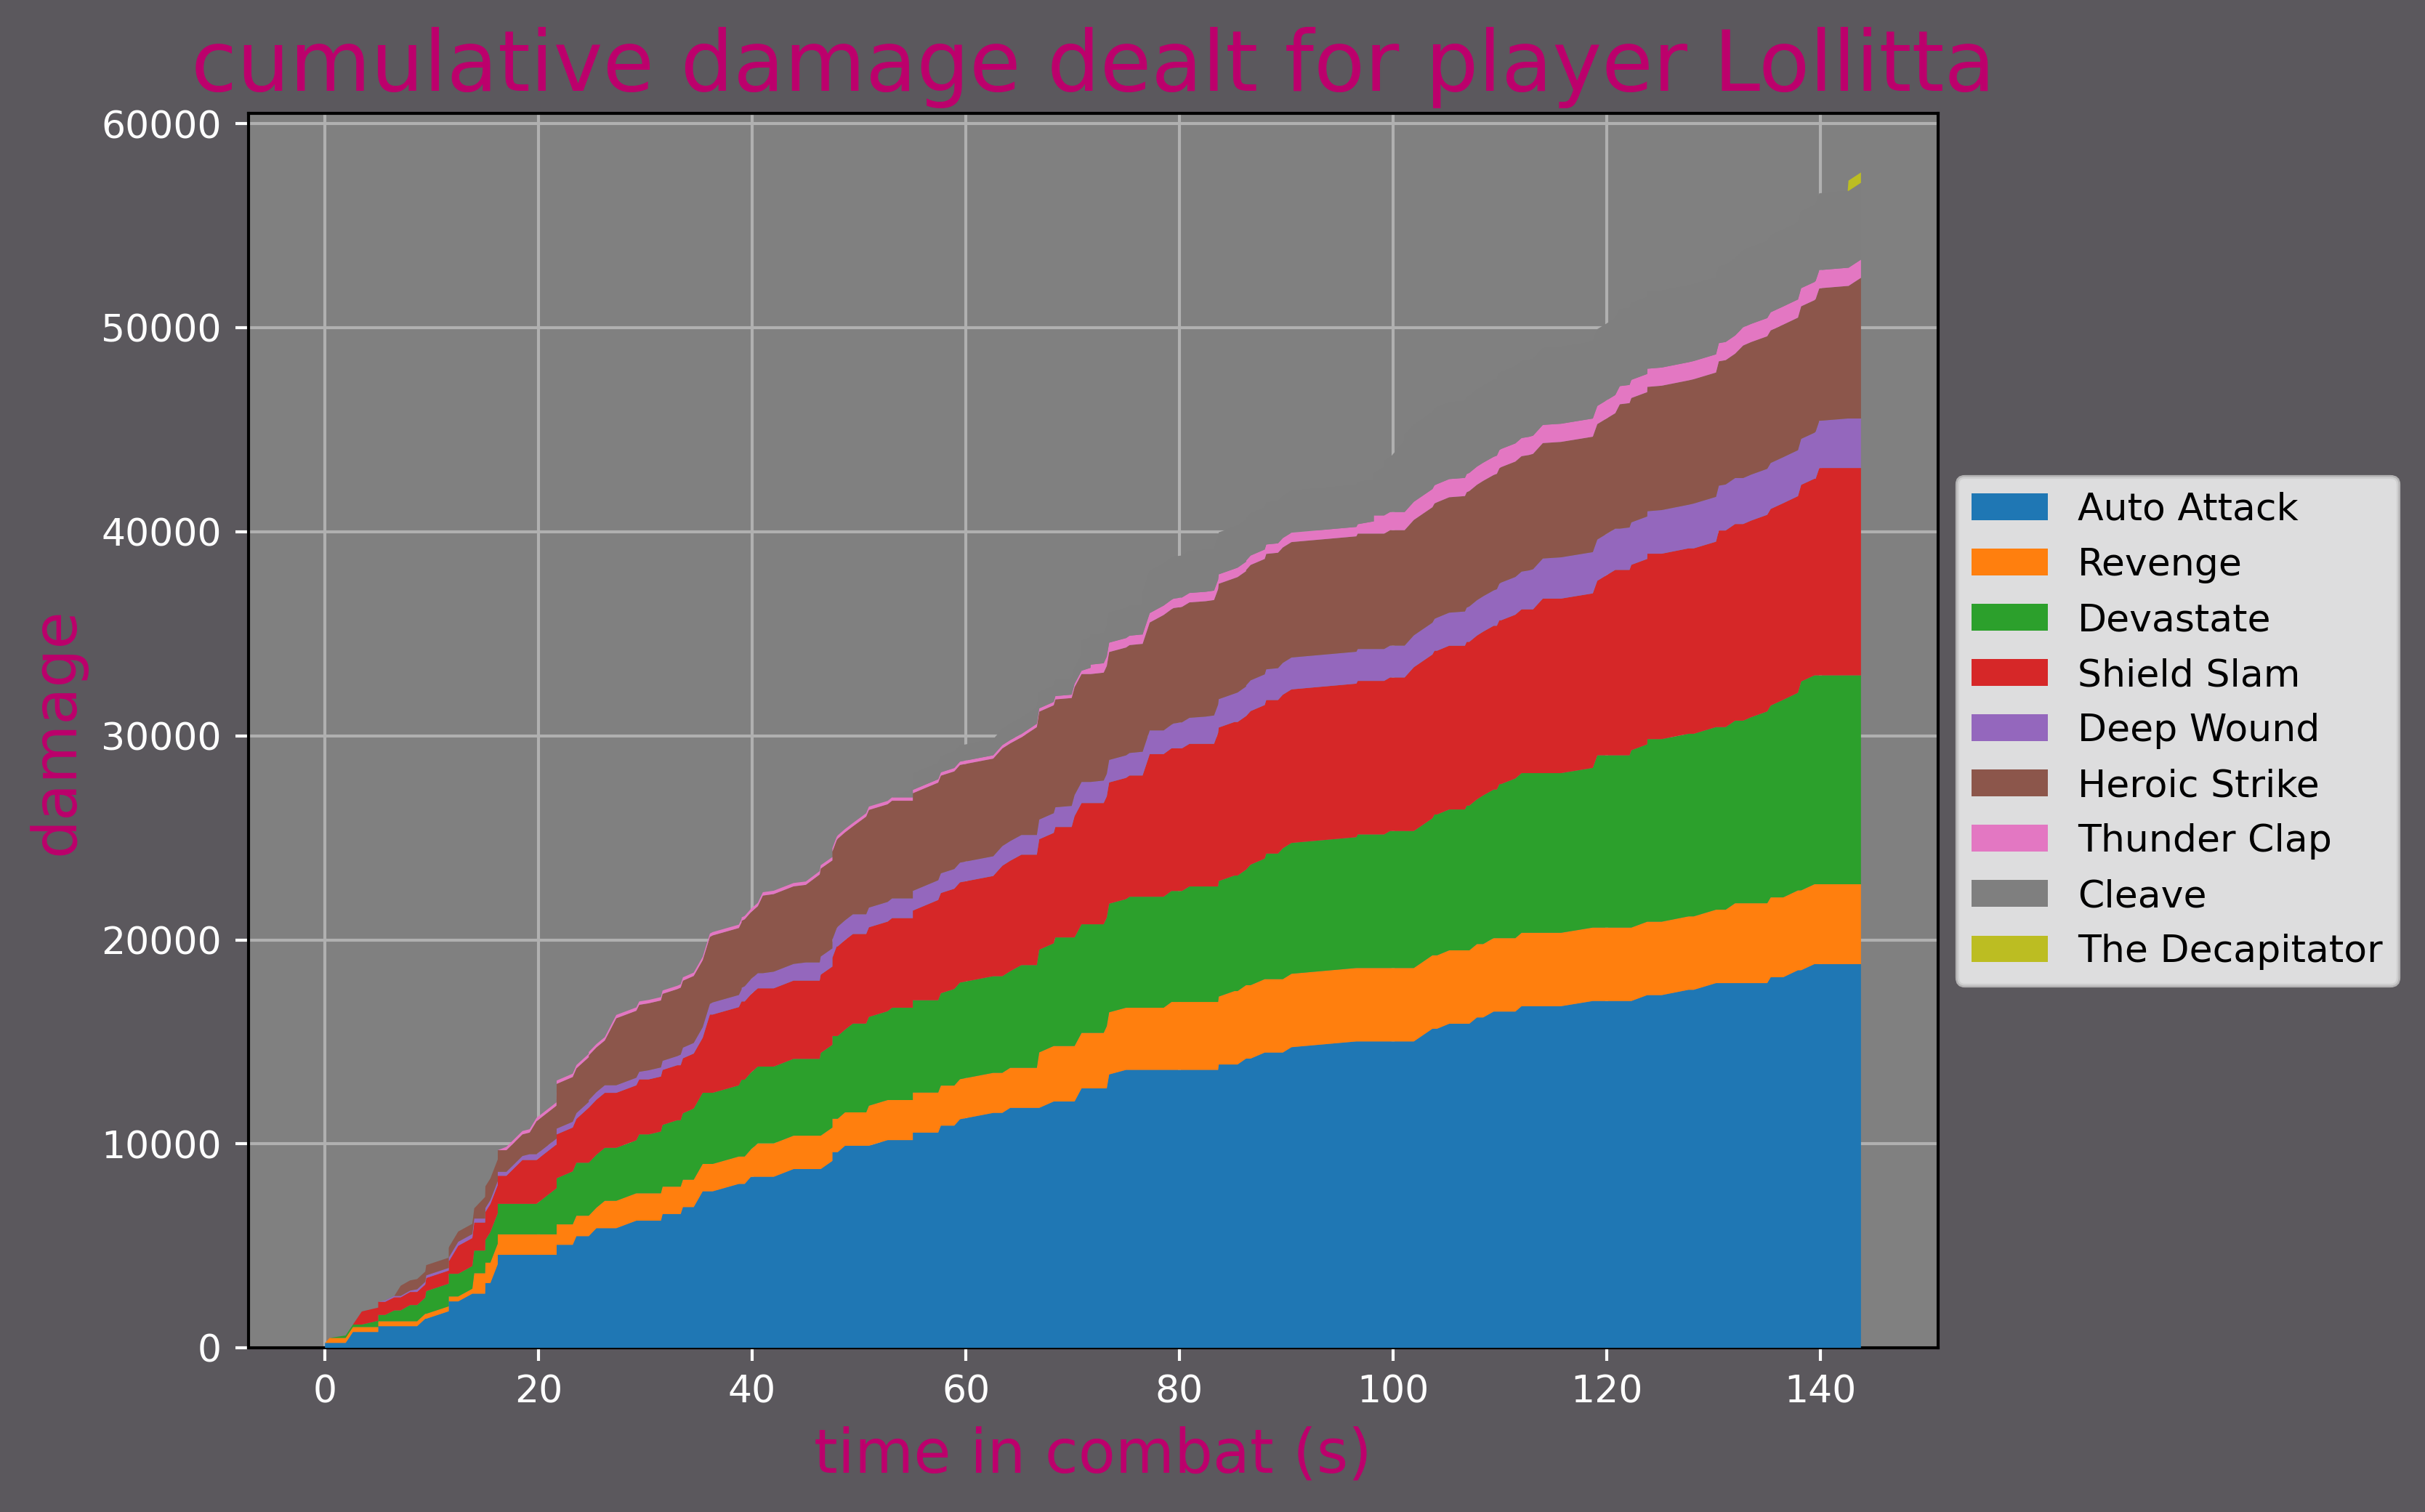

In [114]:
character = 'Lollitta'
chart = Canvas()
chart.ax.stackplot(player_abilities[character]['time_frame'],
                  player_abilities[character]['abilities'].values(),
                  labels = player_abilities[character]['abilities'].keys(),
                  alpha = 1,
                  zorder=3)
chart.ax.set_xlabel('time in combat (s)')
chart.ax.set_ylabel('damage')
chart.ax.set_title(f'cumulative damage dealt for player {character}')
chart.ax.xaxis.label.set_size('16')
chart.ax.yaxis.label.set_size('16')
chart.ax.title.set_size('22')
chart.ax.xaxis.label.set_color('#BC006C')
chart.ax.yaxis.label.set_color('#BC006C')
chart.ax.title.set_color('#BC006C')
chart.ax.tick_params(axis='x', colors='white')
chart.ax.tick_params(axis='y', colors='white')
chart.ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

## Damage Per Source

<AxesSubplot:ylabel='SpellName'>

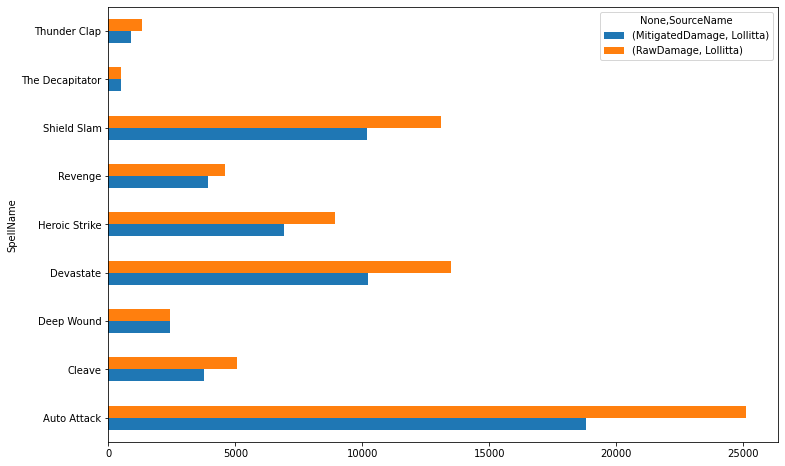

In [91]:
grouped_data = new_df[['SpellName','SourceName','MitigatedDamage','RawDamage']][
    new_df['SourceName']=='Lollitta'].groupby(
    ['SpellName','SourceName']).sum().unstack().fillna(0)
grouped_data.plot.barh(figsize=(12,8))

In [92]:
total_mdamage = int(grouped_data['MitigatedDamage'].sum())
total_rdamage = int(grouped_data['RawDamage'].sum())
print(total_mdamage, total_rdamage)

57611 74496


<AxesSubplot:ylabel='SpellName'>

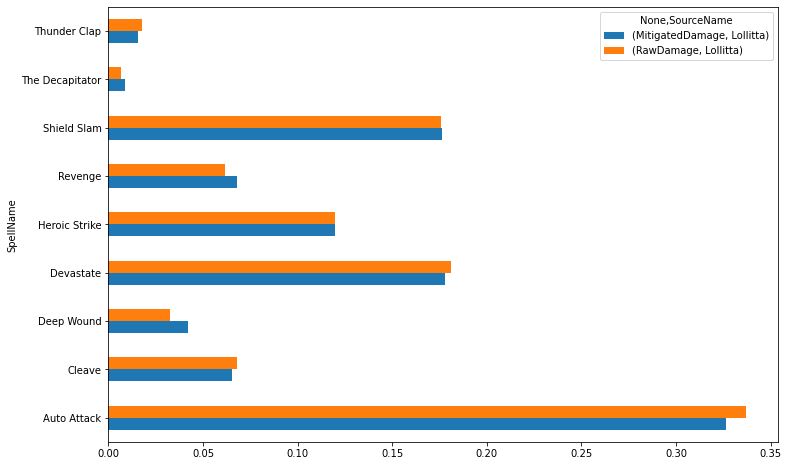

In [93]:
grouped_data = new_df[['SpellName','SourceName','MitigatedDamage','RawDamage']][
    new_df['SourceName']=='Lollitta'].groupby(
    ['SpellName','SourceName']).sum().unstack().fillna(0)
grouped_data['MitigatedDamage'] = grouped_data['MitigatedDamage']/float(total_mdamage)
grouped_data['RawDamage'] = grouped_data['RawDamage']/float(total_rdamage)
grouped_data.plot.barh(figsize=(12,8))

## Gini Coefficient

### Player Real Time DPS

In [94]:
new_df

,MitigatedDamage,SourceName,RawDamage,SourceHuman,DestName,SpellName,timeInCombat
0,248,Lollitta,420,True,Warchief Kargath Bladefist,Auto Attack,0.000
1,1094,Warchief Kargath Bladefist,3704,False,Lollitta,Auto Attack,0.307
2,1314,Warchief Kargath Bladefist,3385,False,Lollitta,Auto Attack,0.323
3,242,Lollitta,410,True,Warchief Kargath Bladefist,Revenge,0.434
4,120,Lollitta,205,True,Warchief Kargath Bladefist,Devastate,1.936
...,...,...,...,...,...,...,...
636,506,Lollitta,505,True,Warchief Kargath Bladefist,The Decapitator,142.651
637,212,Sharpshooter Guard,235,False,Lollitta,Incendiary Shot,142.978
638,372,Sharpshooter Guard,1016,False,Lollitta,Auto Attack,143.293
639,325,Reaver Guard,887,False,Lollitta,Auto Attack,143.293


In [98]:
encounter_ends

1915.3250000476837

In [103]:
new_df3 = new_df.copy()
new_df3['binned'] = pd.cut(new_df3['timeInCombat'],
                 bins=range(-1,math.ceil(encounter_ends-encounter_starts)+1,1))
new_df3

,MitigatedDamage,SourceName,RawDamage,SourceHuman,DestName,SpellName,timeInCombat,binned
0,248,Lollitta,420,True,Warchief Kargath Bladefist,Auto Attack,0.000,"(-1, 0]"
1,1094,Warchief Kargath Bladefist,3704,False,Lollitta,Auto Attack,0.307,"(0, 1]"
2,1314,Warchief Kargath Bladefist,3385,False,Lollitta,Auto Attack,0.323,"(0, 1]"
3,242,Lollitta,410,True,Warchief Kargath Bladefist,Revenge,0.434,"(0, 1]"
4,120,Lollitta,205,True,Warchief Kargath Bladefist,Devastate,1.936,"(1, 2]"
...,...,...,...,...,...,...,...,...
636,506,Lollitta,505,True,Warchief Kargath Bladefist,The Decapitator,142.651,"(142, 143]"
637,212,Sharpshooter Guard,235,False,Lollitta,Incendiary Shot,142.978,"(142, 143]"
638,372,Sharpshooter Guard,1016,False,Lollitta,Auto Attack,143.293,"(143, 144]"
639,325,Reaver Guard,887,False,Lollitta,Auto Attack,143.293,"(143, 144]"


In [104]:
new_df4 = new_df3[new_df3['SourceName'] == character]
new_df4.tail()

,MitigatedDamage,SourceName,RawDamage,SourceHuman,DestName,SpellName,timeInCombat,binned
621,526,Lollitta,764,True,Warchief Kargath Bladefist,Shield Slam,139.918,"(139, 140]"
627,57,Lollitta,57,True,Heathen Guard,Deep Wound,141.229,"(141, 142]"
635,58,Lollitta,57,True,Reaver Guard,Deep Wound,142.575,"(142, 143]"
636,506,Lollitta,505,True,Warchief Kargath Bladefist,The Decapitator,142.651,"(142, 143]"
640,400,Lollitta,580,True,Warchief Kargath Bladefist,Heroic Strike,143.821,"(143, 144]"


In [105]:
grouped = new_df4[['MitigatedDamage','binned']].groupby('binned').sum()
grouped

,MitigatedDamage
binned,
"(-1, 0]",248
"(0, 1]",242
"(1, 2]",120
"(2, 3]",535
"(3, 4]",643
...,...
"(141, 142]",57
"(142, 143]",564
"(143, 144]",400


In [108]:
DPS = sum(grouped['MitigatedDamage'])/(encounter_ends - encounter_starts)
DPS

396.9011795888638

In [25]:
from matplotlib.backends.backend_qt5agg import FigureCanvasQTAgg as FigureCanvas

class Canvas(FigureCanvas):

    def __init__(self):
        fig , self.ax = plt.subplots(figsize = (8,6),dpi=300)
        fig.patch.set_facecolor('#161219')
        fig.patch.set_alpha(0.7)
        fig.savefig('cdps.png',facecolor = fig.get_facecolor(), edgecolor = 'None')
        super().__init__(fig)
        os.remove("cdps.png")
        self.ax.set_facecolor('grey')
        self.ax.grid()
        self.ax.spines['bottom'].set_color('black')
        self.ax.spines['top'].set_color('black') 
        self.ax.spines['right'].set_color('black')
        self.ax.spines['left'].set_color('black')

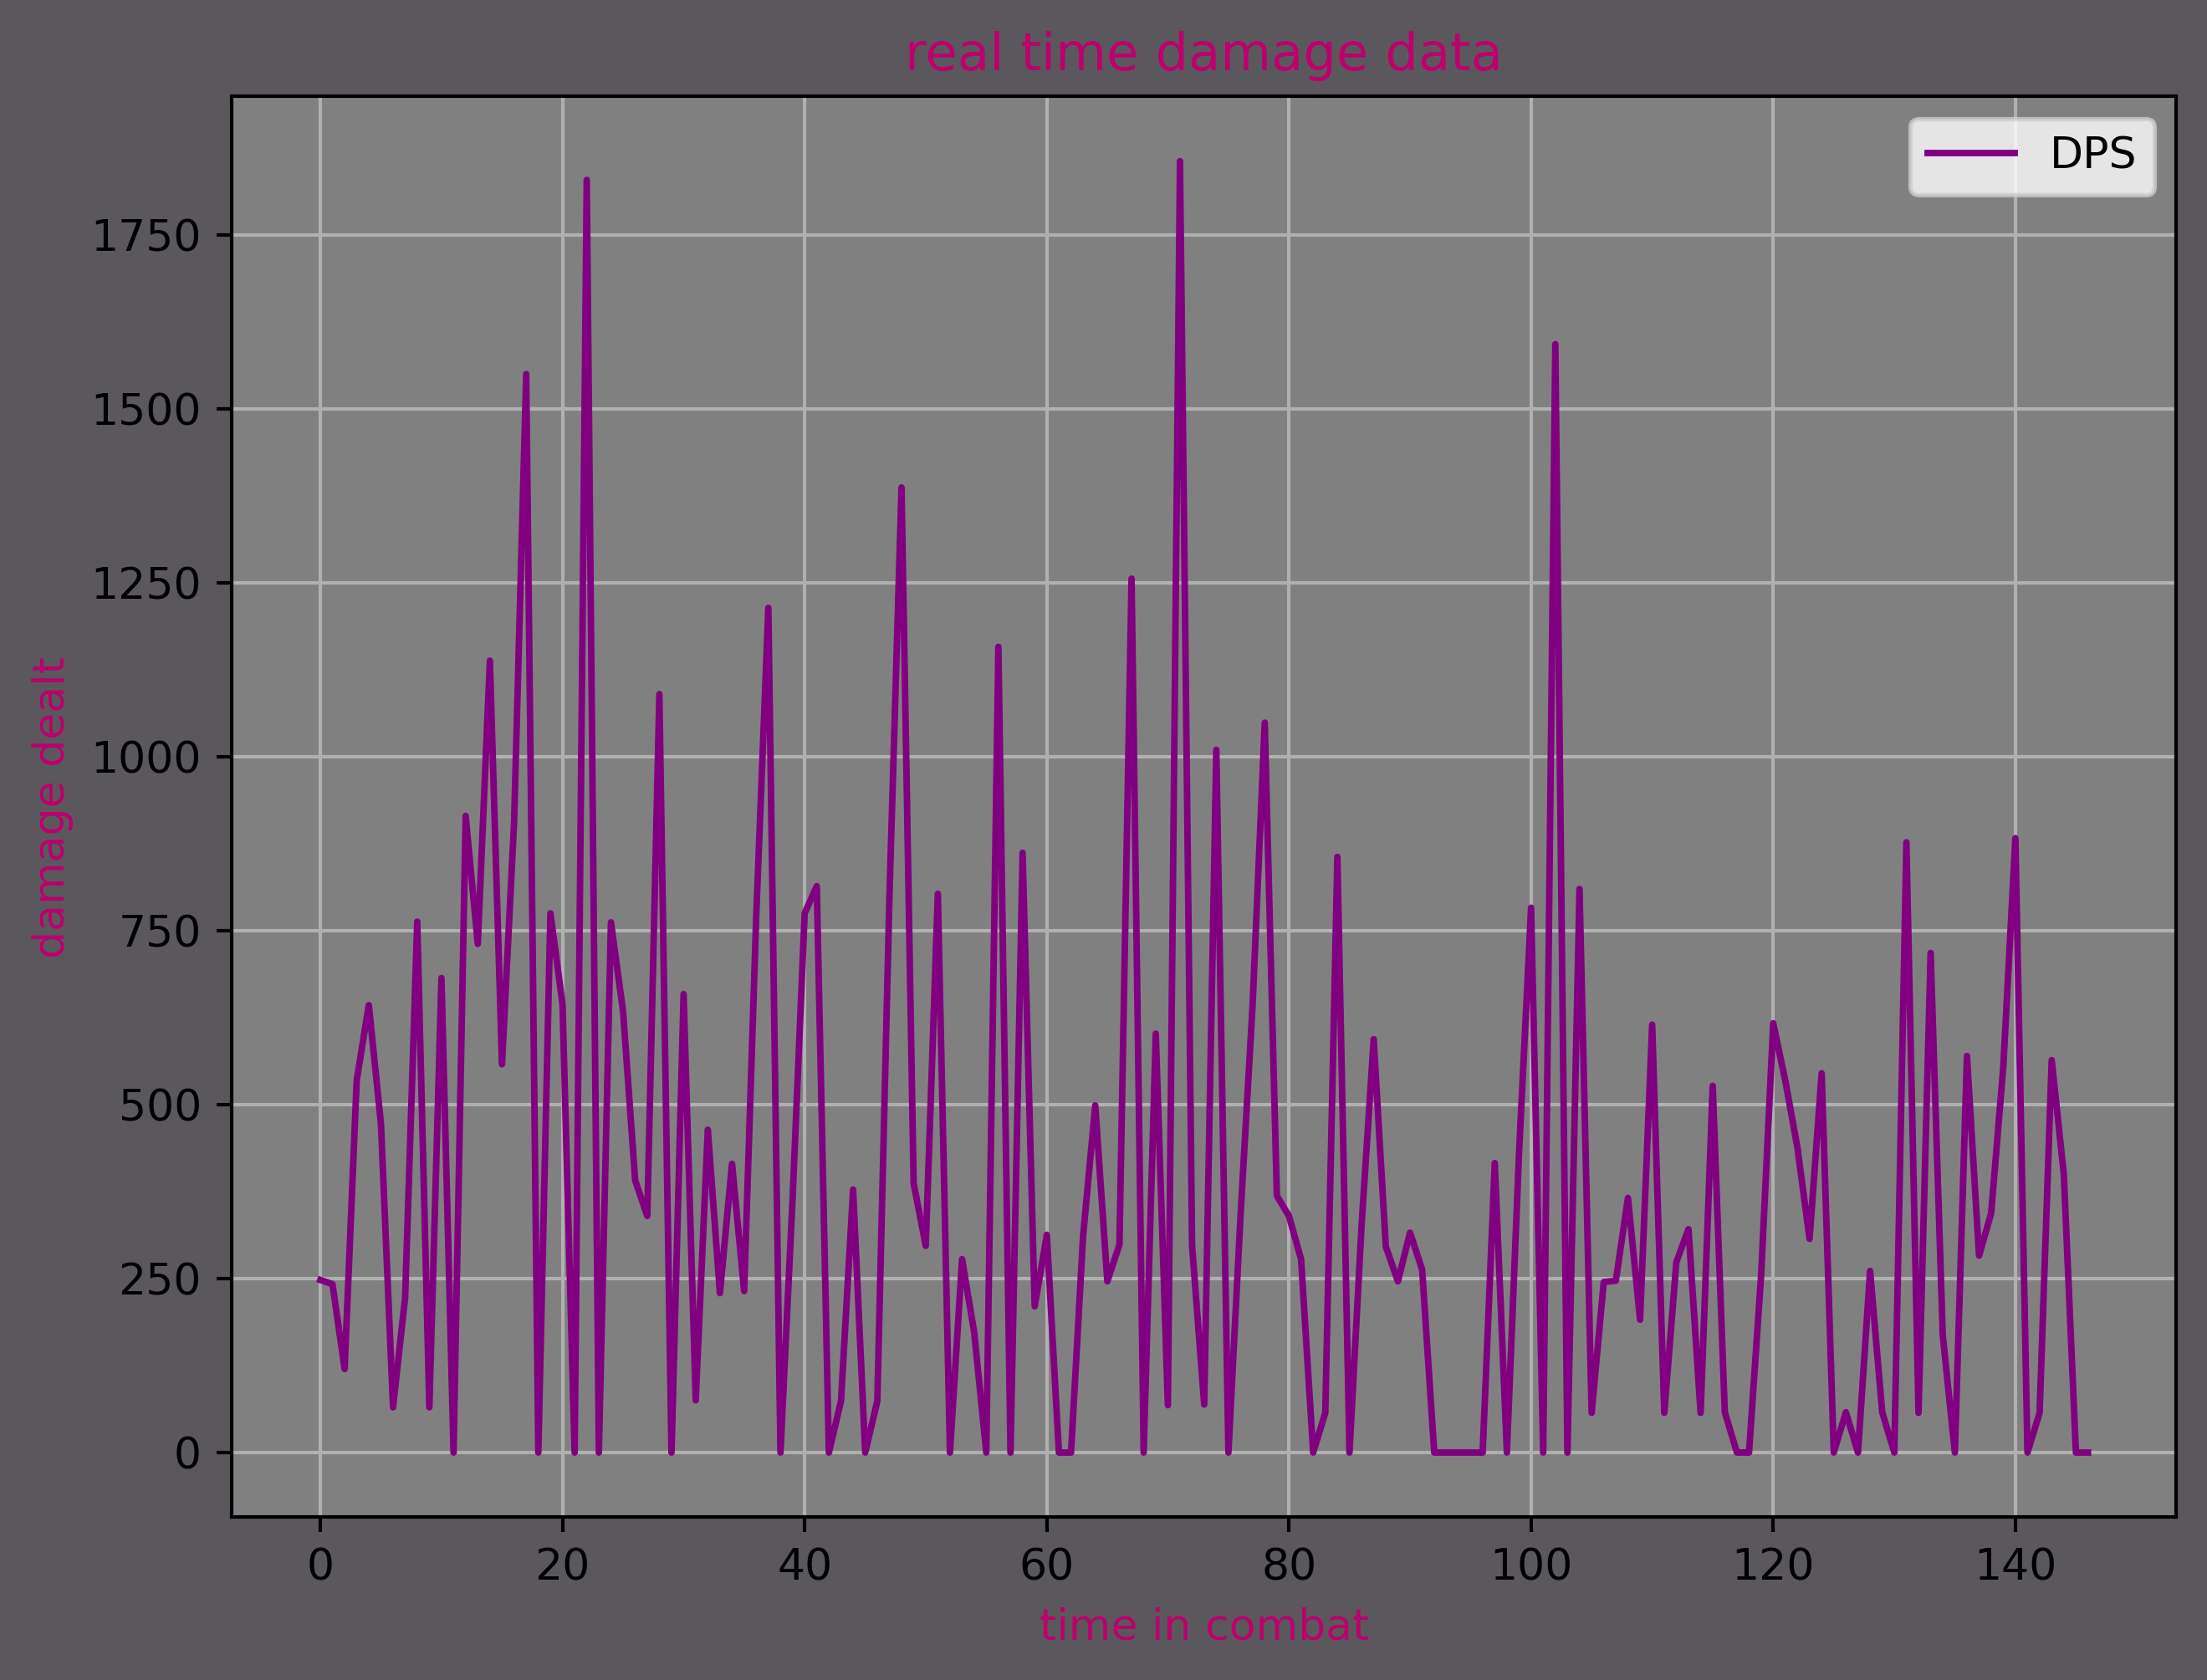

In [119]:
chart = Canvas()
chart.ax.plot(range(0,math.ceil(encounter_ends-encounter_starts)+1,1),
             grouped['MitigatedDamage'],color='purple',label = 'DPS')
chart.ax.set_xlabel('time in combat',color='#BC006C')
chart.ax.set_ylabel('damage dealt',color='#BC006C')
chart.ax.set_title('real time damage data',color='#BC006C')
chart.ax.legend(loc=0)
plt.show()